Notes on the algorithm:
Right now, population is allowed to vary by 2%.
Compactness is allowed to vary by 10%, I've found that 5% doesn't give the algorithm enough freedom to explore all possible states. Could be a problem since we change compactness too much.

### Algorithm

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
precincts = gpd.read_file("/Users/hanlin/Google Drive/CS+/Data/cen_prec_data3")
districts = gpd.read_file("/Users/hanlin/Google Drive/CS+/Data/nc_district_shapefiles") 
districts = districts.to_crs(precincts.crs)

In [49]:
districts["area"] = districts.geometry.area
districts["perimeter"] = districts.geometry.length
districts["PolsbyPopper"] = (4 * math.pi)* (districts.area/(districts.perimeter**2))
districts["ModSchwartz"] = ((2 * math.pi)*((districts.area/math.pi)**0.5))/districts.perimeter

In [50]:
precincts["neighbors"] = precincts.my_neighbo.str.split(", ")
precincts_original = precincts.copy()

1


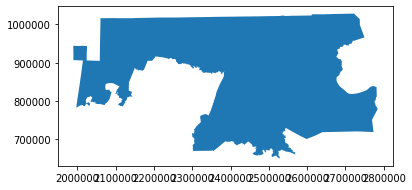

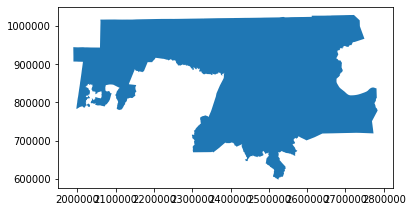

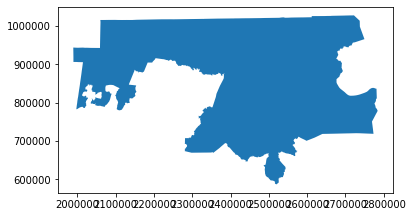

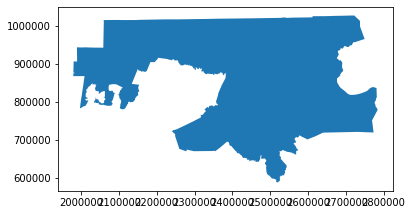

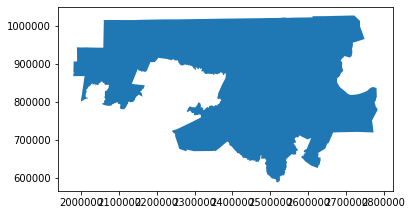

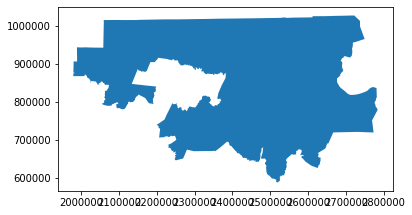

No more valid additions
2


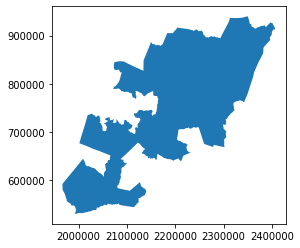

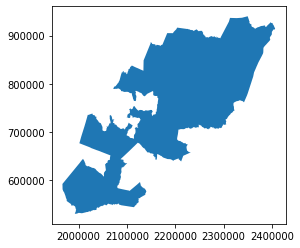

No more valid additions
3


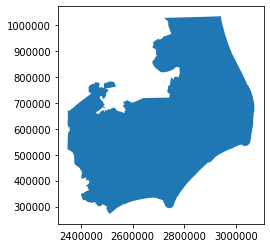

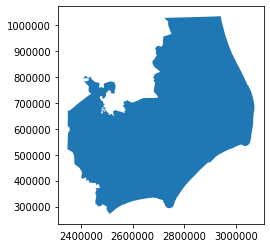

No more valid additions
4


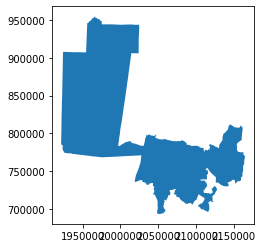

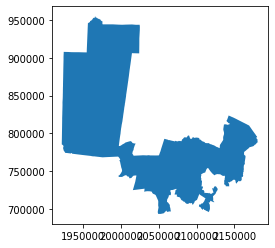

No more valid additions
5
No more valid additions
6


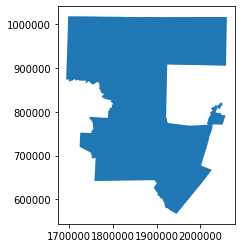

No more valid additions
7
No more valid additions
8


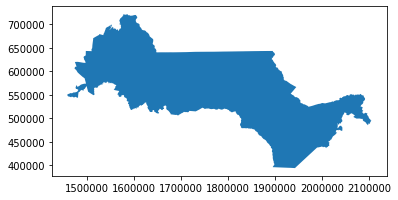

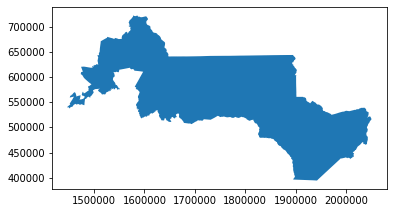

No more valid additions
9


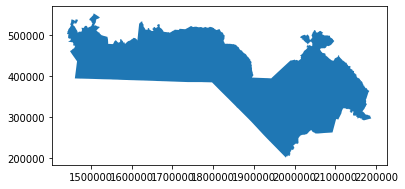

No more valid additions
10


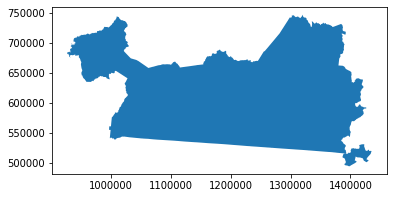

No more valid additions
11


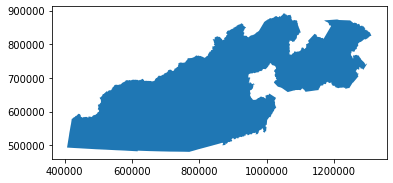

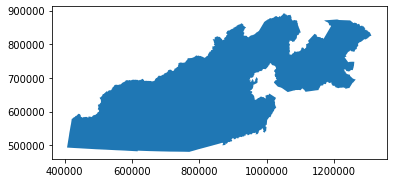

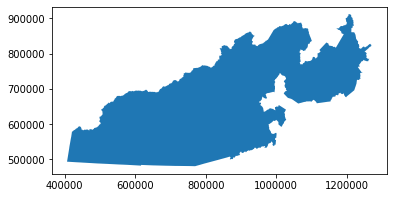

No more valid additions
12
No more valid additions
13


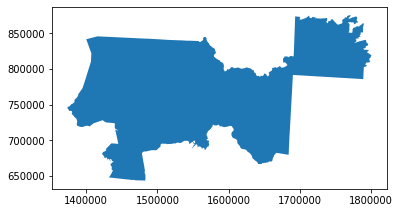

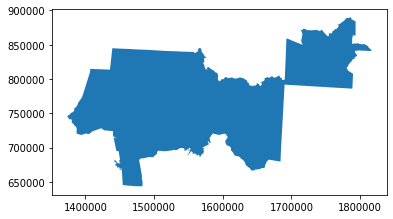

No more valid additions


In [52]:
all_dist_shapes = []   
for NUM in range(1, 14):
    print(NUM)
    ## RESET INITIAL DISTRICTS
    precincts = precincts_original.copy()
    
    ## GET INITIAL DISTRICT SHAPE
    dist_shape = precincts[precincts.district==NUM].unary_union
    
    #Calculate original schwartzberg measure
    orig_schwartz = districts.loc[NUM-1, "ModSchwartz"] 
    
    #Keep track of changes to the evolving precinct (although I don't really use this)
    changelog = gpd.GeoDataFrame()

    i=0
    while True:
        i+= 1
        ### Every 20 iterations, print out the shape
        if i % 20 == 0:
            gpd.GeoSeries(dist_shape).plot()
            plt.show()

        ### GET DISTRICT COPMOSIITON
        dist_comp = precincts.loc[precincts.district==NUM, "loc_prec"].tolist()

        ###NEIGHBORS
        neighbors = set()
        neighbor_list = precincts.loc[precincts.district==NUM, "neighbors"].tolist()
        for one_neighbor_list in neighbor_list:
            for item2 in one_neighbor_list:
                neighbors.add(item2)
        neighbors = neighbors.difference(dist_comp)

        ###BOUNDARY PRECINCTS
        bound_prec = set()
        curr_dist = precincts.loc[precincts.district==NUM]
        for index, row in curr_dist.iterrows():
            if set(row.neighbors) & neighbors: #if a precinct has neighbors which aren't in the district, but rather neighbors:
                bound_prec.add(row.loc_prec)

        ### CALCULATE DISTRICT-LEVEL STATISTICS 
        district_stats = precincts.groupby("district").sum()
        cds = district_stats.loc[NUM] 
        cds["geometry"] = dist_shape
        changelog = changelog.append(cds)
        
        ### CALCULATE CURRENT PARTISAN LEAN
        td = cds.at["total_dem"]
        tr = cds.at["total_rep"]
        tv = cds.at["total_vote"]
        tp = cds.at["total_pop"]
        curr_par = (td - tr)/tv #Positive is democratic lean, negative is republican

        ### CREATE WHAT-IF PRECINCT DF      
        whatif = precincts[precincts['loc_prec'].isin(neighbors|bound_prec)]
        whatif.loc[whatif["loc_prec"].isin(neighbors), "is_neighbor"] = 1
        whatif.loc[whatif["loc_prec"].isin(bound_prec), "is_neighbor"] = -1
        
        whatif["total_pop"] = whatif.is_neighbor * whatif.total_pop
        whatif["total_dem"] = whatif.is_neighbor * whatif.total_dem
        whatif["total_vote"] = whatif.is_neighbor * whatif.total_vote
        whatif["total_rep"] = whatif.is_neighbor * whatif.total_rep

        ### CALCULATE HYPOTHETICAL LEANS AND POPULATION ONTO WHAT_IF GRAPH
        whatif["hyp_lean"] = (td + whatif.total_dem - tr - whatif.total_rep)/(tv + whatif.total_vote)
        whatif["hyp_pop"] = (tp + whatif.total_pop)

        ### SELECT ONLY THE PRECINCTS IN THE RIGHT POP DEV
        whatif = whatif.loc[(whatif.hyp_pop>733499 * .98) & (whatif.hyp_pop<733499*1.02)]
        #print(whatif.shape)

        ### SORT TO PICK BIGGEST PARTISAN LEAN CHANGE
        whatif["lean_chg"] = abs(curr_par) - abs(whatif.hyp_lean) #Must take abs values
        lean_chg = abs(curr_par) - abs(whatif.hyp_lean)
        whatif.sort_values(by="lean_chg", inplace=True, ascending=False) #Sort from highest lean_chg to lowest


        ### START DISSOLVING, CHECK COMPACTNESS AND CONTIGUITY
        no_better_sol = True
        for index, row in whatif.iterrows():
            if row.lean_chg < 0: #If partisan lean only gets worse
                no_better_sol = True
                break
            if row.is_neighbor == -1: #i.e. it's a boundary precinct
                new_shape = dist_shape.difference(row.geometry)
            else: #otherwise it's a neighboring precinct
                new_shape = dist_shape.union(row.geometry) 
            new_schwartz = ((2 * math.pi)*((new_shape.area/math.pi)**0.5))/new_shape.length
            if (new_schwartz > orig_schwartz * 0.90) & (new_schwartz < orig_schwartz * 1.10): 
                if (str(type(new_shape)) == "<class 'shapely.geometry.polygon.Polygon'>"): #Check multipolygon contiguity
                    if len(new_shape.interiors) == 0: #Check for holes
                        no_better_sol = False
                        dist_shape = new_shape
                        if row.is_neighbor == -1:
                            precincts.loc[precincts.loc_prec == row.loc_prec, "district"] =  -1
                            #print("remove" + row.loc_prec + " Partisan: " + str(row.lean_chg))
                        else:
                            precincts.loc[precincts.loc_prec == row.loc_prec, "district"] = NUM
                            #print("add" + row.loc_prec + " Partisan: " + str(row.lean_chg))
                        break

        if no_better_sol==True:
            print("No more valid additions")
            break
            
    ### ADD THE FINAL SWAPPED DISTRICT TO A DF
    district_stats = precincts.groupby("district").sum()
    cds = district_stats.loc[NUM]
    cds["geometry"] = dist_shape
    all_dist_shapes.append(cds)
    


In [62]:
#Transform our finalized districts into a GeoDF
gdf = gpd.GeoDataFrame(all_dist_shapes)
gdf["district"] = gdf.index

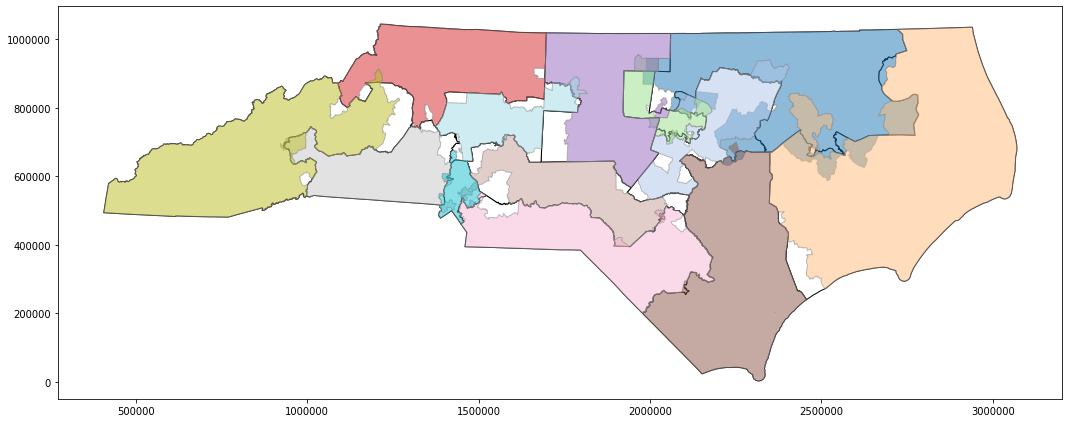

In [69]:
#Plot New District Outlines
base = districts.plot(figsize=(18, 16), edgecolor="black", color="white", linewidth =1)
gdf.plot(ax=base, column = "district", cmap="tab20", alpha=0.5, edgecolor="grey") #Using votes as a proxy for dist

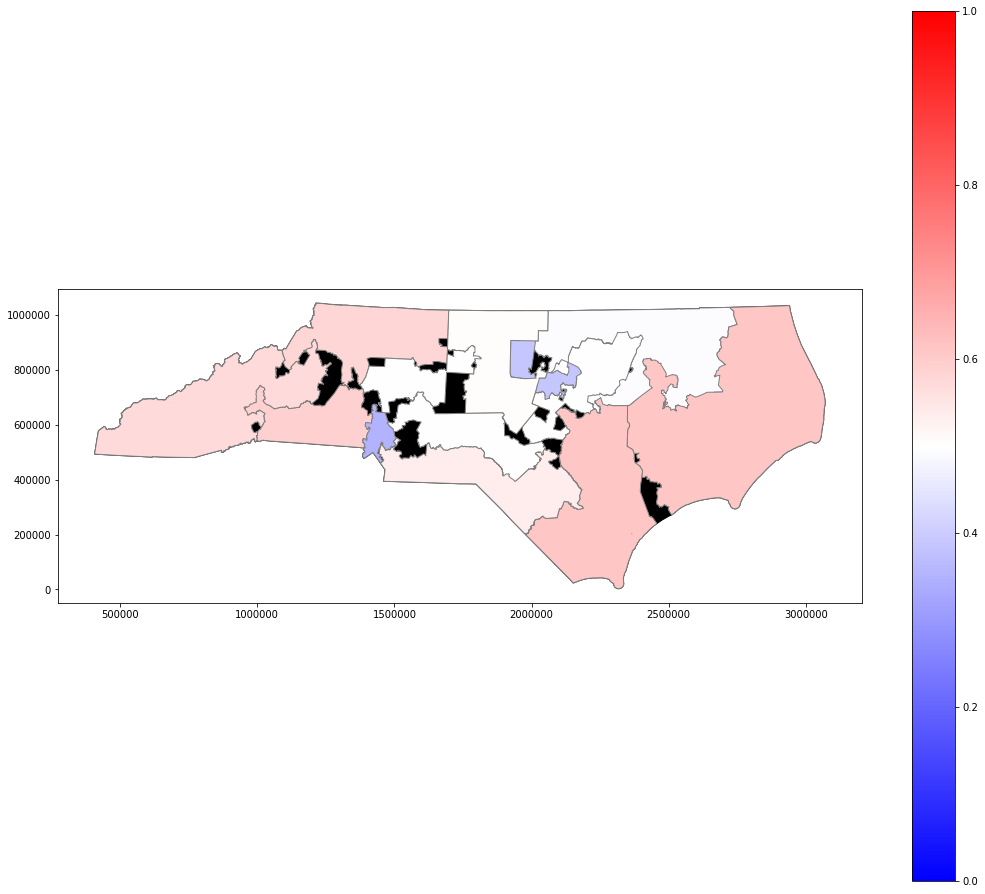

In [88]:
#Plot New  District Partisanness
gdf["rep_prop"] = gdf["total_rep"]/gdf["total_vote"]
base = districts.plot(figsize=(18, 16), edgecolor="black", color="black", linewidth =1)
gdf.plot(ax=base, column = "rep_prop", cmap="bwr", edgecolor="grey", legend=True, vmin=0, vmax=1)

In [71]:
print(orig_schwartz, new_schwartz) #Idk maybe the discrepancy is just an error when stopping the algo

0.4764465025111199 0.4272057261336657


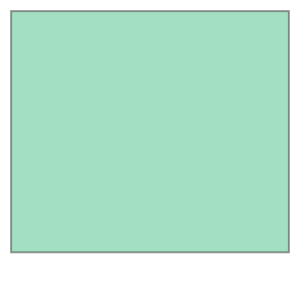

In [29]:
precincts[precincts.district==2].unary_union.envelope

In [27]:
type(test)

shapely.geometry.polygon.Polygon

In [26]:
[list(shp.geometry.exterior[row_id].coords) for row_id in range(shp.shape[0])]

AttributeError: 'Polygon' object has no attribute 'shape'

In [34]:
test2 = np.asarray(precincts[precincts.district==2].unary_union.envelope.exterior.coords)

In [37]:
test2[2]

array([2384425.27618322,  916504.80136798])